# This is so wrong, need major rework 

[1] Need to standardise the measurmenet for errors
[2] Need to rework the input data, You should pay extra attentions to the flow of time
[3] Need to standardise the function of cleaning, processing and preparing dataset 
[4] Need to organise model into functions 
[+] More

In [1]:
import tensorflow as tf 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn

% matplotlib inline
plt.style.use('ggplot')

In [2]:
data = pd.read_csv('tsco_clean.csv')
data.head()

,Date,Open,High,Low,Close,Volume,next_close_is_high,next_close_is_low
0,31-Mar-17,188.55,190.12,185.55,185.60,23980231,-1,-1
1,30-Mar-17,189.35,192.15,188.20,189.00,17279065,0,1
2,29-Mar-17,191.90,191.90,189.22,190.25,16366596,0,1
3,28-Mar-17,190.00,192.00,188.00,191.20,21600784,0,1
4,27-Mar-17,189.75,190.55,187.55,189.95,12319546,1,0


In [3]:
data.describe()

,Open,High,Low,Close,Volume,next_close_is_high,next_close_is_low
count,4000.000000,4000.000000,4000.000000,4000.000000,4.000000e+03,4000.000000,4000.000000
mean,309.560653,312.609585,305.802985,309.845920,2.930987e+07,0.487000,0.491750
std,86.138150,86.946273,85.699447,85.449562,5.136392e+07,0.500393,0.500494
min,-1.000000,-1.000000,-1.000000,139.200000,-1.000000e+00,-1.000000,-1.000000
25%,240.000000,242.750000,236.960000,240.000000,1.529005e+07,0.000000,0.000000
50%,318.750000,321.250000,315.535000,318.650000,2.311368e+07,0.000000,0.000000
75%,381.400000,385.650000,376.787500,381.512500,3.522399e+07,1.000000,1.000000
max,493.000000,494.250000,485.000000,492.000000,1.275697e+09,1.000000,1.000000


(0, 4000)

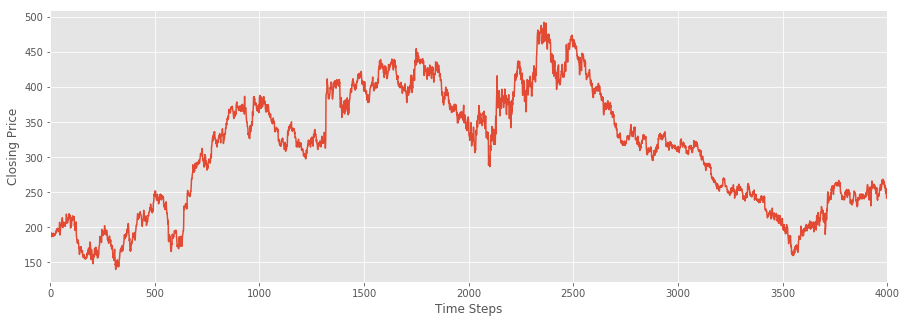

In [13]:
extract = data['Close']
plt.plot(extract.index, extract.values)
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.xlim(0, len(extract))

In [54]:
n_input = 1
n_steps = 14
n_output = 7


learning_rate = 1e-3
n_epoch = 100
epoch_size = 200
n_hidden = 128
n_iter = n_epoch * epoch_size

In [55]:
time = list(range(n_steps, len(extract)-n_steps - n_output))
# Care when adding more values
past = np.empty((len(time), n_steps))
future = np.empty((len(time), n_output))

for i, v in enumerate(time):
    past[i,:] = extract[v-n_steps+1: v+1]
    future[i, :] = extract[v+1:v+n_output+1]
    print('At Time: {} Close: {}' .format(v, extract.iloc[v]))
    print('Past:{}'.format(past[i,:]))
    print('Future:{}'.format(future[i,:]))
    print('----------')

At Time: 14 Close: 191.0
Past:[ 189.    190.25  191.2   189.95  191.    189.6   185.85  188.9   189.
  187.35  186.9   189.4   188.25  191.  ]
Future:[ 188.8   186.4   188.5   188.95  190.3   188.1   188.8 ]
----------
At Time: 15 Close: 188.8
Past:[ 190.25  191.2   189.95  191.    189.6   185.85  188.9   189.    187.35
  186.9   189.4   188.25  191.    188.8 ]
Future:[ 186.4   188.5   188.95  190.3   188.1   188.8   190.15]
----------
At Time: 16 Close: 186.4
Past:[ 191.2   189.95  191.    189.6   185.85  188.9   189.    187.35  186.9
  189.4   188.25  191.    188.8   186.4 ]
Future:[ 188.5   188.95  190.3   188.1   188.8   190.15  188.15]
----------
At Time: 17 Close: 188.5
Past:[ 189.95  191.    189.6   185.85  188.9   189.    187.35  186.9   189.4
  188.25  191.    188.8   186.4   188.5 ]
Future:[ 188.95  190.3   188.1   188.8   190.15  188.15  189.1 ]
----------
At Time: 18 Close: 188.95
Past:[ 191.    189.6   185.85  188.9   189.    187.35  186.9   189.4   188.25
  191.    188.8 

In [56]:
train_ratio = 0.9
train_size = int(len(past) * train_ratio)
break_global = time[train_size]
print('Train/Test Set Break: {}' .format(break_global))

train_past = past[:train_size]
train_past = train_past.reshape((len(train_past), n_steps, n_input))
train_future = future[:train_size]

test_past = past[train_size:]
test_past = test_past.reshape((len(test_past), n_steps, n_input))
test_future = future[train_size:]

Train/Test Set Break: 3582


In [57]:
def my_rnn(x, W, b):
    x = tf.transpose(x, [1, 0, 2])
    x = tf.reshape(x, [-1, n_input])
    x = tf.split(x, n_steps, axis=0)
    
    lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    return tf.nn.bias_add(tf.matmul(outputs[-1], W), b)

In [58]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_output])

W = tf.Variable(tf.truncated_normal([n_hidden, n_output]))
b = tf.Variable(tf.truncated_normal([n_output]))

h = my_rnn(x, W, b)

individual_losses = tf.reduce_sum(tf.squared_difference(h,y), reduction_indices=1)
loss = tf.reduce_mean(individual_losses)
optimiser = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [59]:
%%time 
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for iter in range(n_iter+1):
    # No mini Batch yet
    optimiser.run(feed_dict={x:train_past, y:train_future})
    
    if iter% epoch_size ==0:
        print('Epoch: {} Loss: {}' .format(int(iter/epoch_size), loss.eval(feed_dict={x:train_past, y:train_future})))

Epoch: 0 Loss: 766559.9375
Epoch: 1 Loss: 588563.4375
Epoch: 2 Loss: 514672.71875
Epoch: 3 Loss: 451171.90625
Epoch: 4 Loss: 395010.09375
Epoch: 5 Loss: 345109.84375
Epoch: 6 Loss: 300804.5625
Epoch: 7 Loss: 260145.59375
Epoch: 8 Loss: 225070.953125
Epoch: 9 Loss: 194576.109375
Epoch: 10 Loss: 167719.875
Epoch: 11 Loss: 143028.59375
Epoch: 12 Loss: 122016.828125
Epoch: 13 Loss: 103746.890625
Epoch: 14 Loss: 87887.1328125
Epoch: 15 Loss: 73568.828125
Epoch: 16 Loss: 61372.53125
Epoch: 17 Loss: 51046.09765625
Epoch: 18 Loss: 42341.2578125
Epoch: 19 Loss: 35070.34765625
Epoch: 20 Loss: 29050.80859375
Epoch: 21 Loss: 24107.1953125
Epoch: 22 Loss: 20033.779296875
Epoch: 23 Loss: 16631.349609375
Epoch: 24 Loss: 13757.5263671875
Epoch: 25 Loss: 11345.228515625
Epoch: 26 Loss: 9342.87109375
Epoch: 27 Loss: 7696.8935546875
Epoch: 28 Loss: 6351.6162109375
Epoch: 29 Loss: 5266.00390625
Epoch: 30 Loss: 4361.5
Epoch: 31 Loss: 3622.629150390625
Epoch: 32 Loss: 2938.4140625
Epoch: 33 Loss: 2463.70141

In [61]:
test_loss = loss.eval(feed_dict={x:test_past, y: test_future})
print('Test Loss: {}' .format(test_loss))

Test Loss: 478.2273254394531


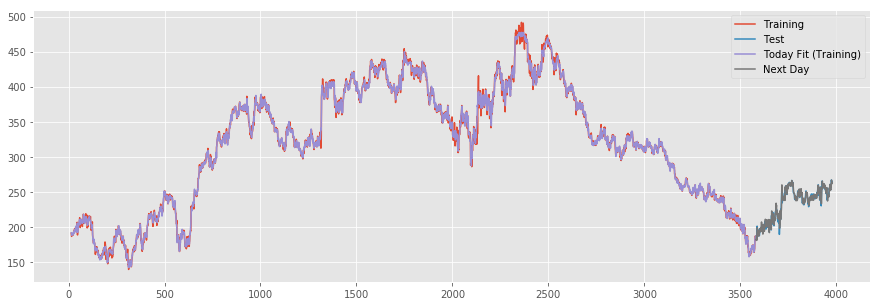

In [62]:
fit = h.eval(feed_dict={x:train_past})
pred = h.eval(feed_dict={x:test_past})
plt.plot(time[:train_size], past[:train_size, -1], label='Training')
plt.plot(time[train_size:], past[train_size:, -1], label='Test')
plt.plot(np.asarray(time[:train_size])+1, fit[:, 0], label='Today Fit (Training)')
plt.plot(np.asarray(time[train_size:])+1, pred[:,0], label='Next Day')
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.legend(loc=1)

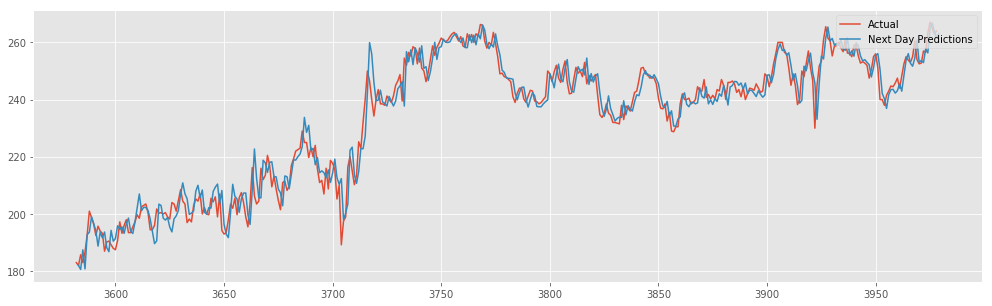

In [85]:
plt.plot(time[train_size:], past[train_size:, -1], label='Actual')
plt.plot(np.asarray(time[train_size:])+1, pred[:,0], label='Next Day Predictions')
#plt.plot(np.asarray(time[train_size:])+7, pred[:,6], label='7 Days Predictions')
fig = plt.gcf()
fig.set_size_inches(17, 5)
plt.legend(loc=1)

Error Mean: -0.12808223695538806
Error STD: 2.663489522636818
RMSE: 2.011678354565983


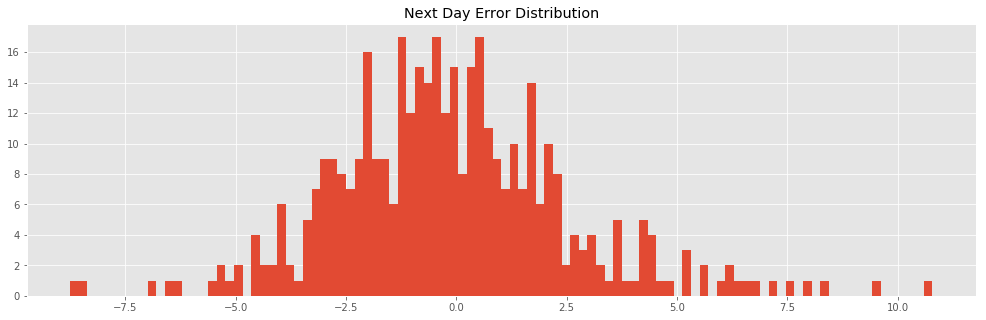

In [14]:
next_day_errors = past[train_size:, -1] - pred[:,0]
plt.hist(next_day_errors, 100)
fig = plt.gcf()
fig.set_size_inches(17, 5)
plt.title('Next Day Error Distribution')
print('Error Mean: {}' .format(np.mean(next_day_errors)))
print('Error STD: {}' .format(np.std(next_day_errors)))
print('RMSE: {}' .format(np.mean(np.absolute(next_day_errors))))

Delta STD: 4.415503511269683
Next Day Delta Mean: 3.287878787878788


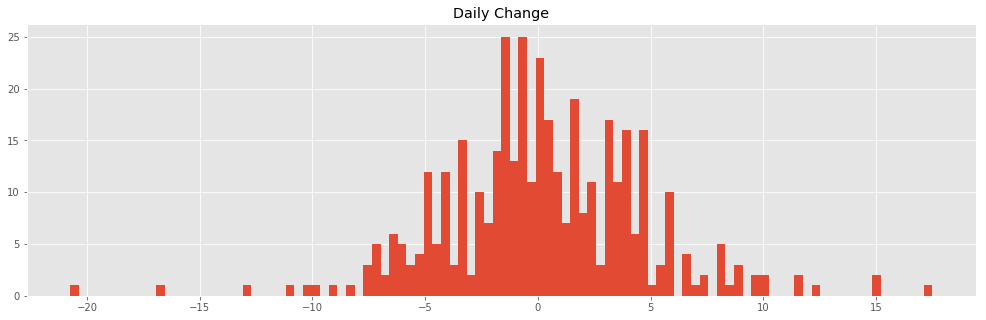

In [15]:
next_day_delta = past[train_size+1:, -1] - past[train_size+1:, -2]
ax = plt.hist(next_day_delta, 100)
fig = plt.gcf()
fig.set_size_inches(17, 5)
plt.title('Daily Change')
print('Delta STD: {}' .format(np.std(next_day_delta)))
print('Next Day Delta Mean: {}' .format(np.mean(np.absolute(next_day_delta))))

In [94]:
p = pred[:,0]
print('Size of p: {}' .format(len(p)))
a = future[train_size:,0]
a = np.asarray(time[train_size:])+1
print('Size of a: {}' .format(len(a)))





Size of p: 397
Size of a: 205
[ 182.00340271  180.62016296  187.47268677  180.80848694  192.78788757
  193.6572113   199.02444458  196.6525116   194.04753113  188.77223206
  193.73277283  191.63395691  193.69927979  188.2686615   186.81988525
  194.2795105   190.50450134  191.40937805  195.88314819  194.59727478
  195.50456238  193.23046875  196.55993652  198.56996155  193.97364807
  193.18788147  197.15296936  202.04747009  206.99850464  201.15145874
  202.33724976  202.28936768  201.24676514  198.28192139  193.99229431
  189.64733887  190.61277771  203.45535278  202.98524475  198.57298279
  197.87593079  198.80531311  195.48390198  193.74113464  198.31681824
  199.38330078  201.29716492  206.94940186  210.89389038  207.1010437
  205.35215759  199.87367249  200.31338501  201.13012695  207.95198059
  210.05456543  205.68995667  208.39849854  200.62055969  199.95397949
  202.2233429   202.07269287  207.86273193  209.40158081  210.46176147
  203.60533142  208.227005    196.41946411  192.